# Лабораторная работа №3 по Цифровой Обработке Изображений на тему "Классификация изображений с использованием Свёрточных Нейронных Сетей"

- [Набор данных](#Набор-данных)
    - [Тестовые изображения](#Тестовые-изображения)
- [Аугментации данных](#Аугментации-данных)
- [Генераторы изображений](#Генераторы-изображений)
- [Модели](#Модели)
- [Обучение](#Обучение)
- [Тестирование](#Тестирование)

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers

TRAIN_PATH = os.path.join(os.getcwd(), 'dataset', 'train')
TEST_PATH = os.path.join(os.getcwd(), 'dataset', 'test')
TEST_CHIHUAHUA = os.path.join(os.getcwd(), 'dataset', 'test', 'Chihuahua')
TEST_MUFFIN = os.path.join(os.getcwd(), 'dataset', 'test', 'Muffin')
IMAGE_SIZE = (170, 170)
# модели
LAYER_WIDTH_32 = 32
LAYER_WIDTH_64 = 64
INPUT_SHAPE = (170, 170, 3)
KERNEL_SIZE = (3, 3)
POOL_SIZE = (2, 2)
MODEL_32_PATH = os.path.join(os.getcwd(), 'model_32.hdf5')
MODEL_64_PATH = os.path.join(os.getcwd(), 'model_64.hdf5')
EPOCHS = 250

## Набор данных

Набор данных состоит из изображений разрешением 170x170 пикселей и разделён на две части: обучающую и тестовую. Обучающая и тестовая части разделены на два класса: собаки породы Чихуахуа и маффины.

In [2]:
def show_images(path, shape, figsize, *, suptitle=None):
    """Показывает изображения.
    
    Args:
        path: путь к директории, из которой показывать изображения.
        shape: форма сколько на рисунке показывать изображений.
        figsize: размер рисунка.
        suptitle: заголовок.
    """
    n_rows, n_columns = shape
    
    file_names = os.listdir(path)
    
    rng = np.random.default_rng()
    random_file_names = rng.choice(file_names, size=(n_rows * n_columns), replace=False)
    
    fig, axes = plt.subplots(*shape, figsize=figsize)
    axes = axes.flatten()
    for ax, random_file_name in zip(axes, random_file_names):
        random_image = plt.imread(os.path.join(path, random_file_name))
        ax.imshow(random_image)
        ax.set_axis_off()
    fig.suptitle(suptitle, fontsize=20)
    plt.show(fig)

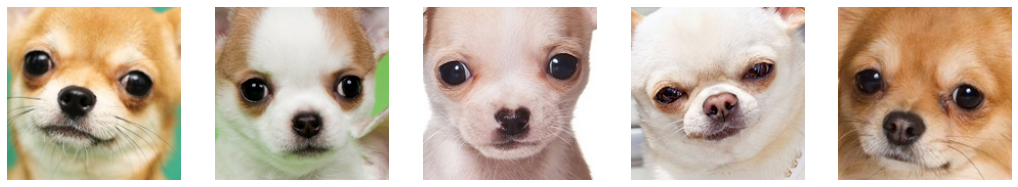

In [3]:
show_images(os.path.join(TRAIN_PATH, 'Chihuahua'), (1, 5), (18, 4))

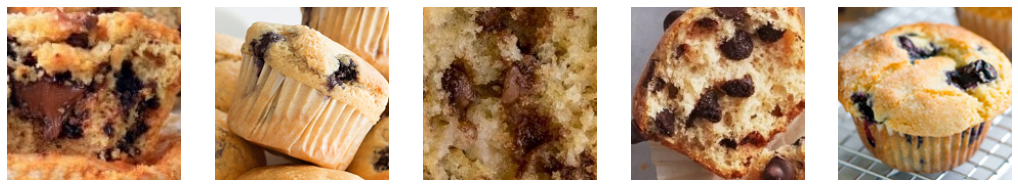

In [4]:
show_images(os.path.join(TRAIN_PATH, 'Muffin'), (1, 5), (18, 4))

### Тестовые изображения

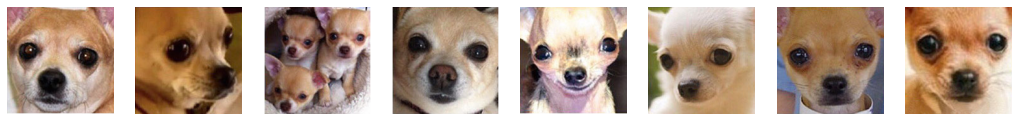

In [5]:
show_images(os.path.join(TEST_PATH, 'Chihuahua'), (1, 8), (18, 4))

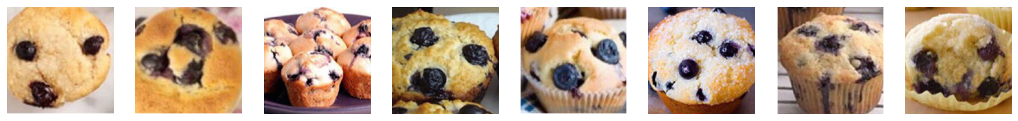

In [6]:
show_images(os.path.join(TEST_PATH, 'Muffin'), (1, 8), (18, 4))

### Настройка CPU/GPU

In [7]:
tf.config.experimental.set_visible_devices([], 'GPU')

## Аугментации данных

Давайте взглянем на примеры аугментации данных. Какие они бывают.

In [8]:
def show_augmentaion(augmentaion, **kwargs):
    """Показывает примеры аугментированных изображений.
    
    Args:
        augmentaion (str): названиме аугментации.
        **kwargs: именованные параметры к аугментации.
    """
    path = os.path.join(os.getcwd(), 'Dataset', 'augmentations', augmentaion)
    
    # удаляем содержимое папки, если оно есть
    file_names = os.listdir(path)
    if file_names:
        for file_name in file_names:
            os.remove(os.path.join(path, file_name))
    
    augmentaion_generator = tf.keras.preprocessing.image.ImageDataGenerator(**kwargs)
    augmentaion_datagen = augmentaion_generator.flow_from_directory(
        TRAIN_PATH, target_size=IMAGE_SIZE, save_to_dir=path, save_format='png')
    next(augmentaion_datagen)
    show_images(path, (1, 5), (18, 4), suptitle=augmentaion)

Found 109 images belonging to 2 classes.


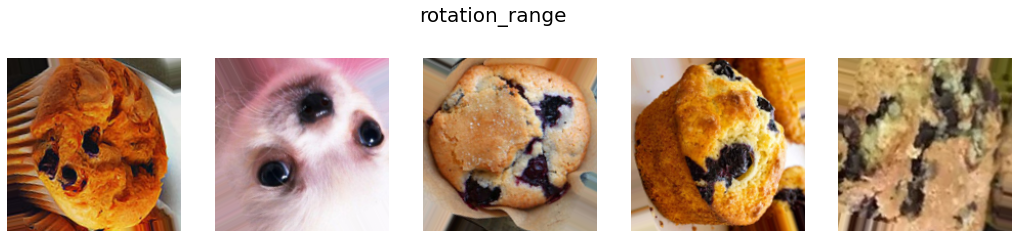

In [9]:
show_augmentaion('rotation_range', rotation_range=180)

Found 109 images belonging to 2 classes.


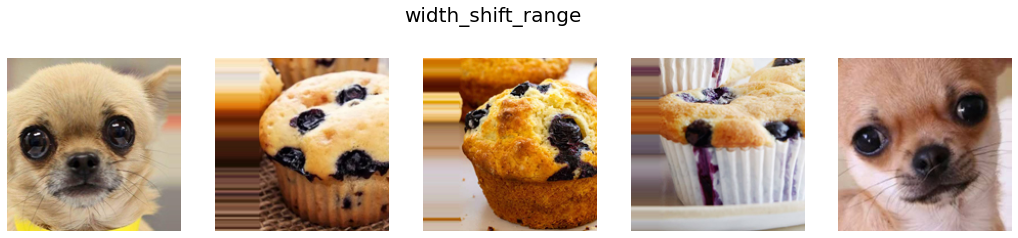

In [10]:
show_augmentaion('width_shift_range', width_shift_range=50)

Found 109 images belonging to 2 classes.


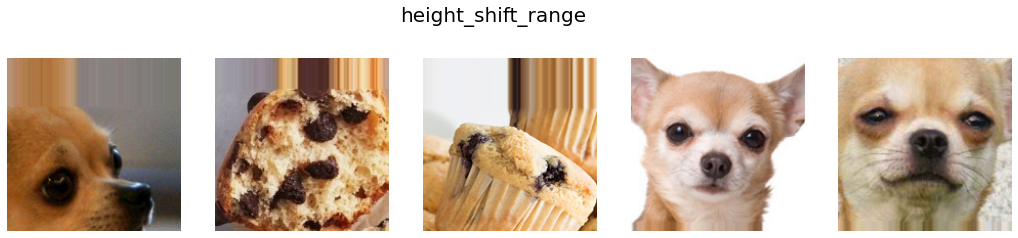

In [11]:
show_augmentaion('height_shift_range', height_shift_range=50)

Found 109 images belonging to 2 classes.


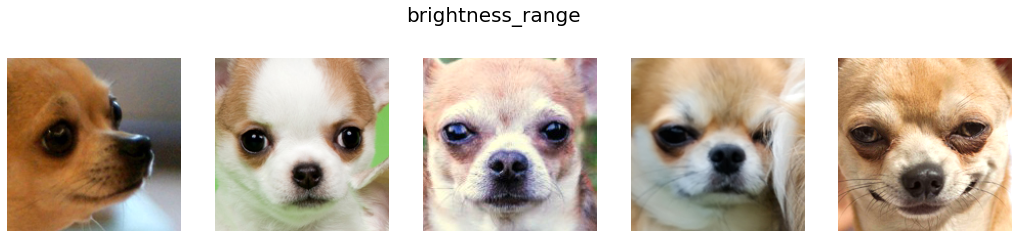

In [12]:
show_augmentaion('brightness_range', brightness_range=(1., 1.2))

Found 109 images belonging to 2 classes.


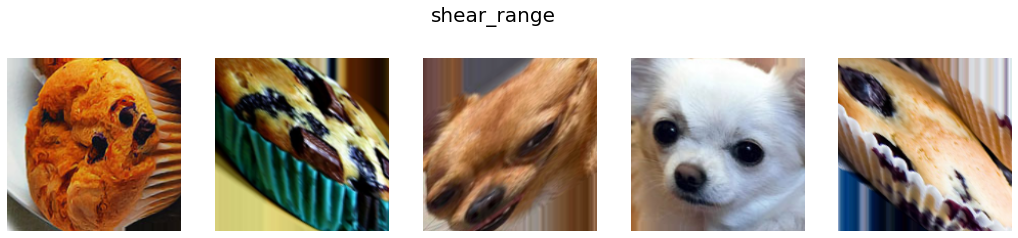

In [13]:
show_augmentaion('shear_range', shear_range=50.0)

Found 109 images belonging to 2 classes.


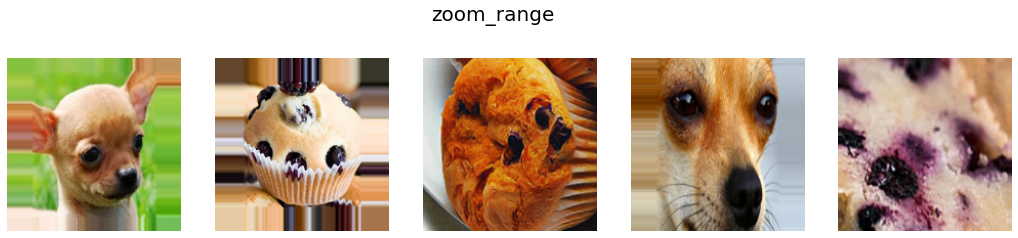

In [14]:
show_augmentaion('zoom_range', zoom_range=0.5)

Found 109 images belonging to 2 classes.


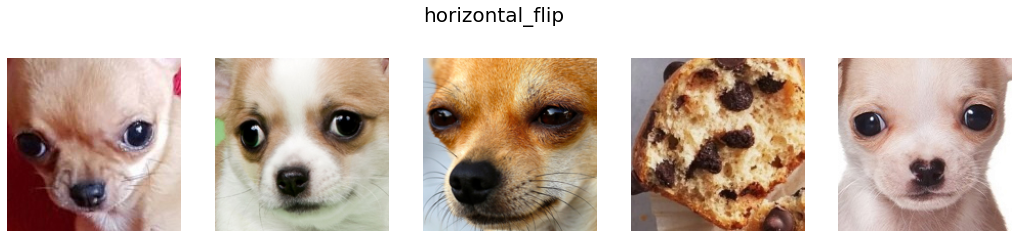

In [15]:
show_augmentaion('horizontal_flip', horizontal_flip=True)

Found 109 images belonging to 2 classes.


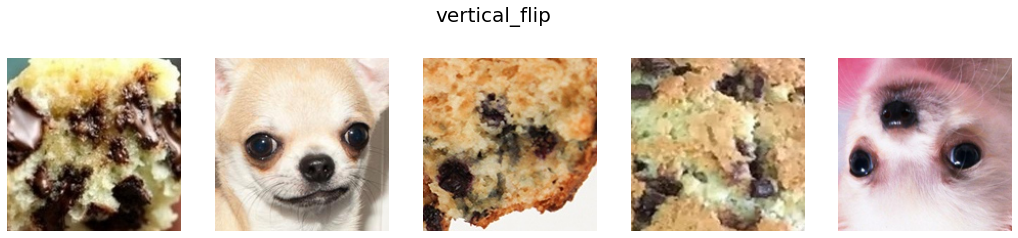

In [16]:
show_augmentaion('vertical_flip', vertical_flip=True)

Found 109 images belonging to 2 classes.


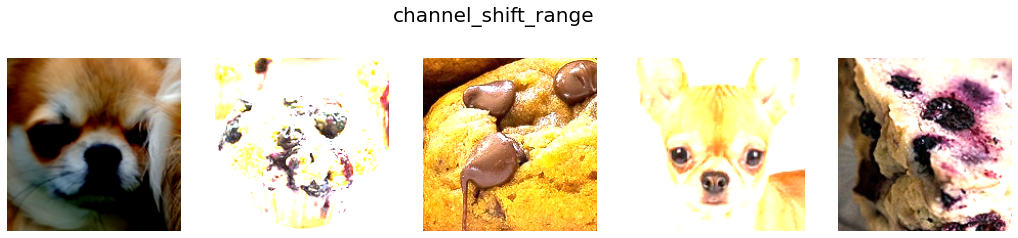

In [17]:
show_augmentaion('channel_shift_range', channel_shift_range=200.)

In [18]:
AUGMENTATION_SETTINGS = dict(
    rotation_range=45,
    width_shift_range=20,
    height_shift_range=20,
    zoom_range=0.2,
    fill_mode='reflect',
    horizontal_flip=True)

Found 109 images belonging to 2 classes.


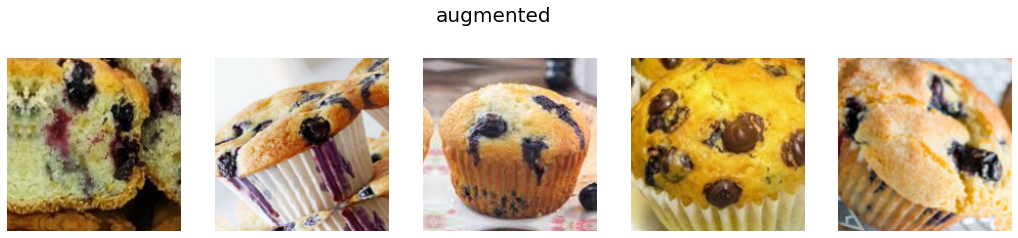

In [19]:
show_augmentaion('augmented', **AUGMENTATION_SETTINGS)

## Генераторы изображений

In [20]:
train_val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255, validation_split=0.2, **AUGMENTATION_SETTINGS)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_generator = train_val_datagen.flow_from_directory(
    TRAIN_PATH, target_size=IMAGE_SIZE, class_mode='categorical', batch_size=32, subset='training')
val_generator = train_val_datagen.flow_from_directory(
    TRAIN_PATH, target_size=IMAGE_SIZE, class_mode='categorical', batch_size=32, subset='validation')
test_generator = test_datagen.flow_from_directory(
    TEST_PATH, target_size=IMAGE_SIZE, class_mode='categorical', batch_size=1)

Found 88 images belonging to 2 classes.
Found 21 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Модели

In [21]:
def create_model(layer_width):
    """Создаёт модель.

    Args:
        layer_width (int): ширина слоёв.

    Returns:
        model: собственно модель.
    """
    model = tf.keras.Sequential([
        layers.Conv2D(
            filters=layer_width,
            kernel_size=KERNEL_SIZE,
            padding='same',
            input_shape=INPUT_SHAPE,
            activation='relu',
            use_bias=True),
        layers.MaxPooling2D(pool_size=POOL_SIZE),
        layers.Conv2D(
            filters=layer_width,
            kernel_size=KERNEL_SIZE,
            padding='same',
            activation='relu',
            use_bias=True),
        layers.MaxPooling2D(pool_size=POOL_SIZE),
        layers.Flatten(),
        layers.Dense(layer_width, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(layer_width, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax'),
    ])
    return model

In [22]:
model_32 = create_model(LAYER_WIDTH_32)
model_64 = create_model(LAYER_WIDTH_64)

model_32.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_64.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

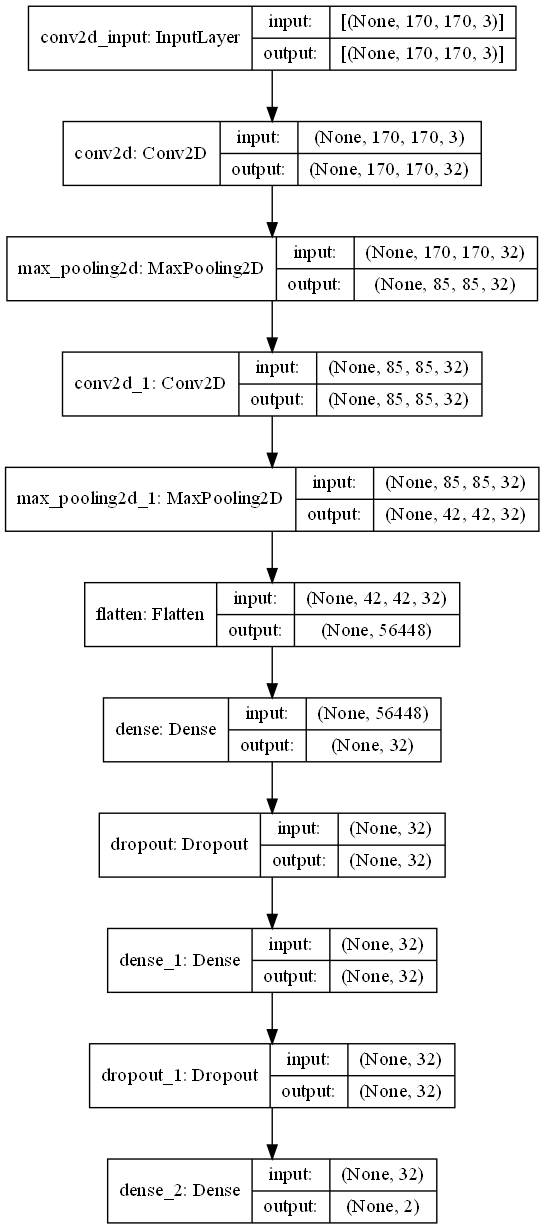

In [23]:
tf.keras.utils.plot_model(model_32, to_file='model_32.png', show_shapes=True, rankdir='TB', dpi=100)

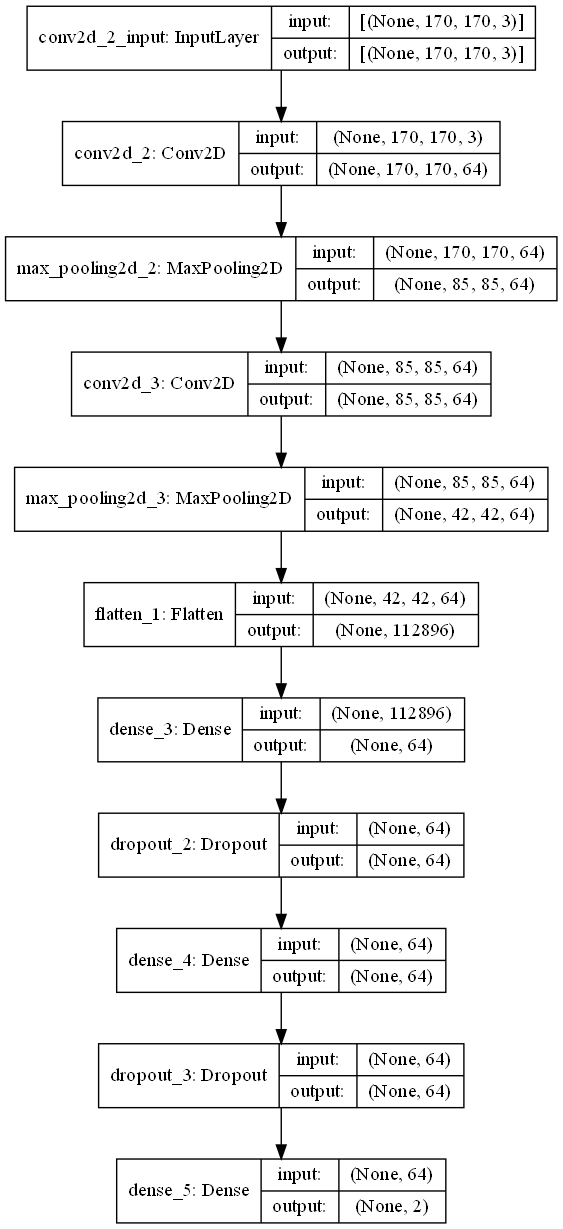

In [24]:
tf.keras.utils.plot_model(model_64, to_file='model_64.png', show_shapes=True, rankdir='TB', dpi=100)

## Обучение

In [25]:
checkpoint_32 = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_32_PATH, monitor='val_accuracy', save_best_only=True, mode='max')
checkpoint_64 = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_64_PATH, monitor='val_accuracy', save_best_only=True, mode='max')
callbacks_list_32 = [checkpoint_32]
callbacks_list_64 = [checkpoint_64]

history_32 = model_32.fit(
    train_generator, epochs=EPOCHS, verbose=0, callbacks=callbacks_list_32, validation_data=val_generator)
history_64 = model_64.fit(
    train_generator, epochs=EPOCHS, verbose=0, callbacks=callbacks_list_64, validation_data=val_generator)

In [26]:
def plot_history(history, mode):
    """Визуализирует историю обучения.
    
    Args:
        history: собственно история.
        mode: {'accuracy', 'loss'} что отображать точность или потери.
    """
    ax = plt.subplot()
    ax.plot(history.history[f'{mode}'])
    ax.plot(history.history[f'val_{mode}'])
    ax.set_xlabel('epochs')
    ax.set_ylabel(f'{mode}')
    ax.legend(['train', 'val'])

    plt.show()

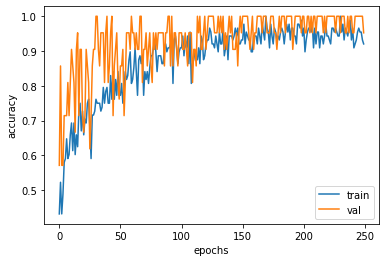

In [27]:
plot_history(history_32, 'accuracy')

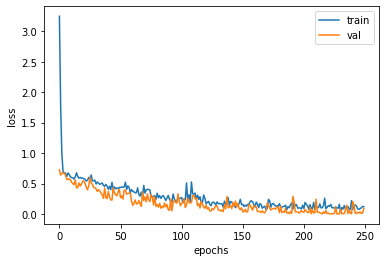

In [28]:
plot_history(history_32, 'loss')

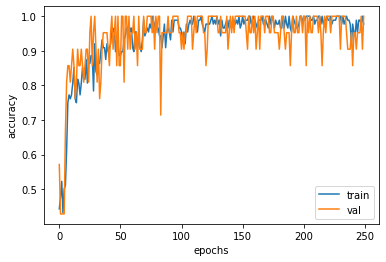

In [29]:
plot_history(history_64, 'accuracy')

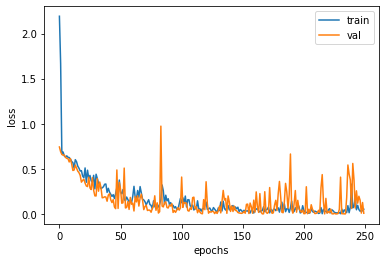

In [30]:
plot_history(history_64, 'loss')

## Тестирование

In [31]:
test_image_paths_chihuahua = [os.path.join(TEST_CHIHUAHUA, file_name) for file_name in os.listdir(TEST_CHIHUAHUA)]
test_image_paths_muffin = [os.path.join(TEST_MUFFIN, file_name) for file_name in os.listdir(TEST_MUFFIN)]

test_image_paths = test_image_paths_chihuahua + test_image_paths_muffin
true_labels = ['chihuahua'] * len(test_image_paths_chihuahua) + ['muffin'] * len(test_image_paths_muffin)

best_model_32 = tf.keras.models.load_model(MODEL_32_PATH)
best_model_64 = tf.keras.models.load_model(MODEL_64_PATH)


def load_image(path):
    """Загружает изображение в пригодном для tensoflow формате.
    
    Args:
        path: путь, по которому лежит изображение.

    Returns:
        image: изображение в прогодном для tensorflow формате.
    """
    raw = tf.io.read_file(path)
    image = tf.io.decode_jpeg(raw, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image[tf.newaxis]
    return image


def show_predictions(model, test_image_paths, true_labels):
    """Показывает предсказания для тестовых изображений.
    
    Args:
        model: модель, котолрая будет предсказывать.
        test_image_paths: список с путями, по которым лежат тестовые изображения.
        true_labels: список с правильными метками.
    """
    fig, axes = plt.subplots(4, 4, figsize=(18, 8))
    axes = axes.flatten()

    for ax, test_image_path, label in zip(axes, test_image_paths, true_labels):
        image = plt.imread(test_image_path)
        ax.imshow(image)
        ax.set_axis_off()

        image = load_image(test_image_path)
        predict = model.predict(image)

        ax.set_title(f'true label - {label}\n chihuahua - {predict[0][0]:2.2%}\n muffin - {predict[0][1]:2.2%}')

    plt.subplots_adjust(hspace=1)
    plt.show()

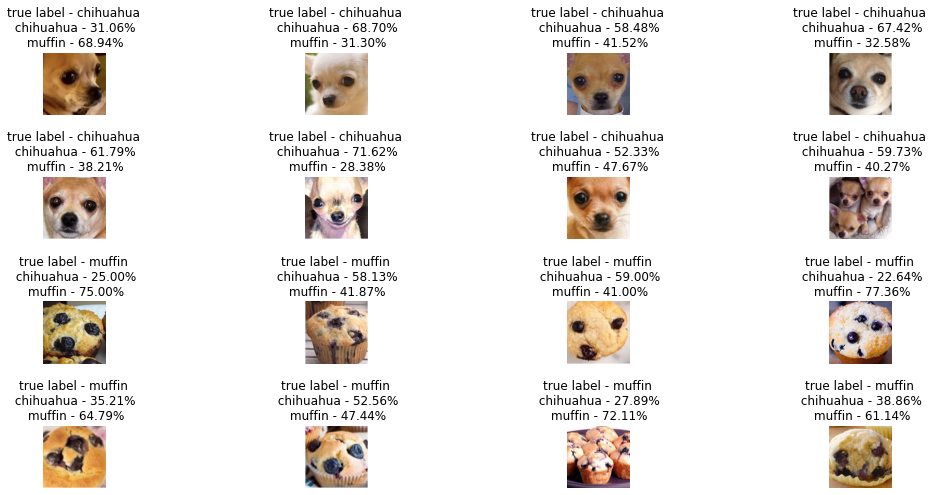

In [32]:
show_predictions(best_model_32, test_image_paths, true_labels)

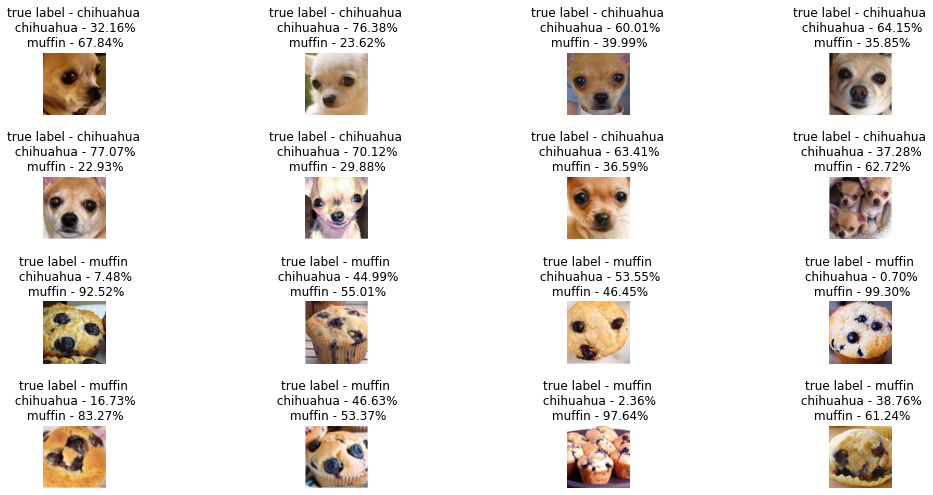

In [33]:
show_predictions(best_model_64, test_image_paths, true_labels)

In [34]:
best_model_32.evaluate(test_generator)

16/16 [==============================] - 0s 9ms/step - loss: 0.5531 - accuracy: 0.7500


[0.5531132221221924, 0.75]

In [35]:
best_model_64.evaluate(test_generator)

16/16 [==============================] - 0s 16ms/step - loss: 0.4555 - accuracy: 0.7500


[0.45547568798065186, 0.75]